In [1]:
import os
import sys
import numpy  as np
import pylab  as pl
import healpy as hp

import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.environ['HOME'] + '/DESI/')

In [3]:
# import pubplot

In [4]:
def II(x):
    '''
    Int rounder
    '''
    return int(np.floor(x)) 

In [5]:
def cp2props(p, nside=1):
    '''
    properties of a polar cap pixel.
    '''
    
    ph  = (p+1) / 2
    
    Iph = II(ph)
    
    # ring index: 1 <= i < nside
    i   = II(np.sqrt(ph - np.sqrt(Iph))) + 1
    
    if (i < 1) | (i >= nside):
        return None, None, None, None
    
    z   = 1 - i*i /3. / nside / nside
    
    # 1 <= j <= 4i
    j   = p + 1 - 2 * i *(i-1)
    
    if (j < 1) | (j > 4 * i):
        return None, None, None, None
    
    s   = 1
    phi = (np.pi / 2. / i) * (j - s/2)
    
    return i, j, phi, z

In [6]:
def ep2props(p, nside=1):
    '''
    properties of an equatorial pixel.
    '''
    
    ph = p - 2 * nside * (nside - 1)
    
    # nside <= i <= 2 * nside
    i = II(ph / 4 / nside) + nside
    '''
    if (i < nside) | (i > 2 * nside):
        return None, None, None, None
    ''' 
    # 1 <= j <= 4 * nside 
    j = np.fmod(ph, 4 * nside) + 1
    '''
    if (j < 1) | (j > 4 * nside):
        return None, None, None, None
    '''
    z = 4./3. - 2 * i / 3. / nside
    
    # phase shift along the ring.
    s = np.fmod(i - nside + 1, 2)
    
    phi = (np.pi / 2. / nside) * (j - s/2)
        
    return i, j, phi, z

In [7]:
def hp_boundary(phis, k, nside=1, cap=True, reverse=True):
    '''
    Bounding arcs of a healpixel
    '''
    # eqn. 22 of https://arxiv.org/pdf/astro-ph/0409513.pdf    
    phits_r = np.clip(np.fmod(phis, np.pi/2.), a_min=1.e-16, a_max=1.e99)
    phits   = 2. * np.fmod(phis, np.pi/2.) - np.pi
    
    if cap:        
        if reverse:
            z = 1. - (k*k /3./nside/nside) * (np.pi / 2. / phits_r)**2.
    
        else:
            z = 1. - (k*k /3./nside/nside) * (np.pi / (phits))**2.
    
        z[(z <= 2./3.)] = np.nan
        
    else:
        z = 2./3. -4.*k/3./nside + 8. * phis / 3. / np.pi
        z[(z >  2./3.) | (z < -2./3.)] = np.nan
    
    return  z

Text(0, 0.5, '$z = \\cos(\\theta)$')

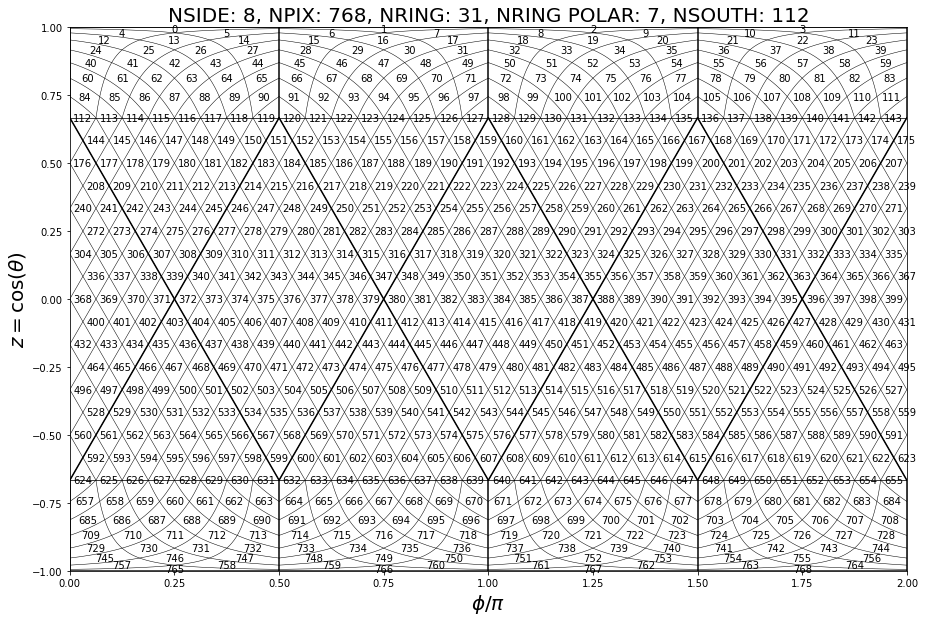

In [13]:
phis    = np.arange(0.0, 2.0 * np.pi, 1.e-3)
phits   = np.fmod(phis, np.pi/2.)

fig, ax = plt.subplots(1,1,figsize=(15, 10)) 

pl.sca(ax)

pl.axhline( 2/3., c='k', lw=0.75)
pl.axhline(-2/3., c='k', lw=0.75)

# pl.plot(phis / np.pi,  phits, c='k', lw=1.5)

# BASE:
nside = 1
npix  = 12 * nside * nside

for b in np.arange(0, 14, 1):
    pl.vlines(b / 2., color='k', lw=1.5, ymin=2./3., ymax=1.)
    pl.vlines(b / 2., color='k', lw=1.5, ymin=-1.0, ymax=-2./3.)

for kk in np.arange(0, npix, 1):
    bs  = hp_boundary(phis, kk, nside=nside, cap=False)
    
    pl.plot(phis / np.pi,  bs, c='k', lw=1.5)
    pl.plot(phis / np.pi, -bs, c='k', lw=1.5)

##  NSIDE
nside       = 8
npix        = 12 * nside * nside
nring       =  4 * nside -1 
nring_polar = nside - 1

# N pixel-in-ring cap  = 4 * ring index.
# N pixel-in-ring belt = 4 * nside.

nsouth      = npix 
nsouth     -= (4 * nside) * (nring - 2 * (nside-1))
nsouth     /= 2
nsouth      = int(nsouth)

ks    = np.arange(0, npix, 1)

for k in ks: 
    # PIXEL CENTERS
    i, j, phi, z = cp2props(k, nside=nside)
    
    bs  = hp_boundary(phis, k, nside=nside, cap=False)
    
    pl.plot(phis / np.pi,  bs, c='k', lw=0.5)
    pl.plot(phis / np.pi, -bs, c='k', lw=0.5)
    
    if (i == None) | (j == None):
        i, j, phi, z = ep2props(k, nside=nside)                

        if (z > 2./3.) | (z < -2./3.):
            continue
        
        # pl.plot(phi / np.pi,  z, marker='^', c='k', markersize=2)
        # pl.plot(phi / np.pi, -z, marker='^', c='k', markersize=2)

        plt.text(phi / np.pi,   z, f'{k}', horizontalalignment='center', verticalalignment='center')

        if (z == 2./3.):
            # Equidistant spacing on a ring. TBC.
            plt.text(2. - phi / np.pi,  -z,  '{}'.format(npix - k - 1), horizontalalignment='center', verticalalignment='center')
        
        continue
    
    bs = hp_boundary(phis, k, nside=nside, cap=True, reverse=False)
    pl.plot(phis / np.pi,   bs, c='k', lw=0.5)
    pl.plot(phis / np.pi,  -bs, c='k', lw=0.5)
    
    bs = hp_boundary(phis, k, nside=nside, cap=True, reverse=True)
    pl.plot(phis / np.pi,   bs, c='k', lw=0.5)
    pl.plot(phis / np.pi,  -bs, c='k', lw=0.5)
    
    # pl.plot(phi / np.pi,  z, marker='^', c='m', markersize=2)
    # pl.plot(phi / np.pi, -z, marker='^', c='m', markersize=2)
     
    plt.text(phi / np.pi,   z, f'{k}',              horizontalalignment='center', verticalalignment='center')
    
    # Equidistant spacing on a ring. TBC.
    plt.text(2. - phi / np.pi,  -z, '{}'.format(npix-k), horizontalalignment='center', verticalalignment='center')
    
pl.title(f'NSIDE: {nside}, NPIX: {npix}, NRING: {nring}, NRING POLAR: {nring_polar}, NSOUTH: {nsouth}', fontsize=20)
    
pl.xlim(0.,  2.)
pl.ylim(-1., 1.)

pl.xlabel(r'$\phi / \pi$',       fontsize=20)
pl.ylabel(r'$z = \cos(\theta)$', fontsize=20)

In [14]:
nside, npix, nring

(8, 768, 31)

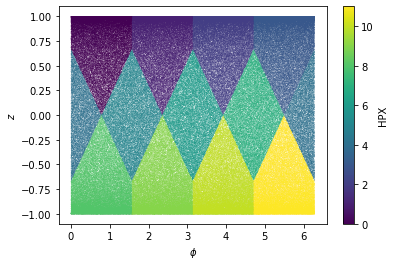

In [116]:
thetas = np.random.uniform(0.,      np.pi, size=500000)
phis   = np.random.uniform(0., 2. * np.pi, size=500000)

zs     = np.cos(thetas)

pos    = np.c_[phis, thetas]

idx    = hp.ang2pix(1, thetas, phis, nest=True, lonlat=False)

pl.scatter(phis, zs, marker='.', lw=0.0, c=idx, s=1)

pl.xlabel(r'$\phi$')
pl.ylabel(r'$z$')

pl.colorbar(label='HPX')

Text(0, 0.5, '$z = \\cos$(colatitude)')

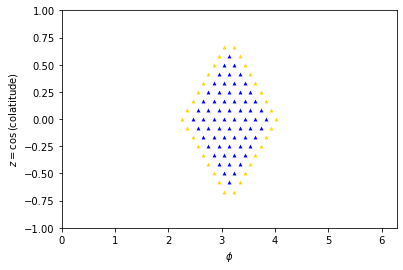

In [118]:
idx          = [6]

hpmap        = np.arange(hp.nside2npix(1))
hpmap        = np.array([x in idx for x in hpmap]).astype(int)

hpmap        = hp.ud_grade(hpmap, nside_out=8, order_in='RING', order_out='RING')
ipix         = np.arange(len(hpmap))[hpmap > 0.0]

neighbors    = hp.pixelfunc.get_all_neighbours(8, thetas, phis, nest=False, lonlat=False)
neighbors    = np.unique(neighbors)
neighbors    = [x for x in neighbors if x not in ipix]

# [neighbors]
to_plot      = [neighbors, ipix]
colors       = ['gold', 'blue']

for pp, cc in zip(to_plot, colors):
    thetas, phis = hp.pix2ang(8, pp, nest=False, lonlat=False)
    zs           = np.cos(thetas)
    
    pl.scatter(phis, zs, marker='^', lw=0.0, s=15, color=cc)

pl.xlim(0.0, 2. * np.pi)
pl.ylim(-1., 1.)

pl.xlabel(r'$\phi$')
pl.ylabel(r'$z = \cos$(colatitude)')

## TODO:  pixel indexing

In [9]:
def int2vec(integer):
    return [np.int(x) for x in list(bin(integer)[2:].zfill(2))]

In [10]:
def displace(quadrant):
    _displacement               = np.zeros(4).reshape(2, 2)
    
    perturb_idx                 = tuple(int2vec(quadrant))
    
    # print(perturb_idx)
    
    _displacement[perturb_idx] += 1.0
    
    return _displacement

In [11]:
class pixel():    
    def __init__(self, nside=1, max_levels=1, parent=None, quadrant=None):
        _displacement = np.zeros(4).reshape(2, 2)
                
        if quadrant != None:
            perturb_idx                = int2vec(quadrant)
            _displacement[perturb_idx] = displace(quadrant)
            
        if (nside == 1):            
            self.level    = 0
            self.quadrant = quadrant
            self.parent   = parent
        
            # Fig. 1 of https://arxiv.org/pdf/astro-ph/0409513.pdf
            # bottom right, top right, bottom left, top left.
            self.center       = [0.5 * displace(3)]
            self.corners      = [displace(q) for q in range(4)]
            self.displacement = None
        
        else:
            self.parent       = parent
            self.level        = parent.level + 1
            
            self.center       = [parent.corners[0] + 0.5 * displace(3)]
            self.corners      = [parent.corners[0] + displace(q) for q in range(4)]
        
            # print('----  {}  ----'.format(self.level))
            # print(self.center)
        
        if self.level > max_levels:
            self.children     = None
        
        else:
            self.children     = {}
            
            for quad in range(4):
                self.children[quad] = pixel(nside + 1, parent=self, quadrant=quad)

In [12]:
x = pixel(max_levels=1)

/tmp/ipykernel_50408/902373251.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return [np.int(x) for x in list(bin(integer)[2:].zfill(2))]


# Done.